In [71]:
# Standard imports
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from time import time
import pandas as pd


from Jet_Observables import Gaussian
from src.Observables import CustomObservable

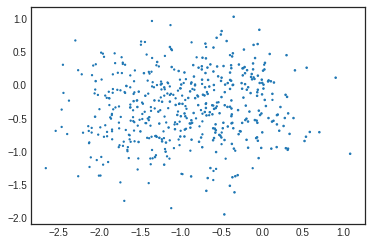

In [72]:
# Bimodal distributions

num_events = 25
events = []

N = 500

for i in range(num_events):

    loc1 = np.random.uniform(size = (int(N/2),2)) * 4 -2
    for j in range(loc1.shape[0]):
        loc1[j,:] = loc1[0,:]
    samples1 = np.random.normal(loc = loc1, scale = 0.5)

    loc2 = np.random.uniform(size = (int(N/2),2)) * 4 -2
    for j in range(loc2.shape[0]):
        loc2[j,:] = loc2[0,:]
    samples2 = np.random.normal(loc = loc2, scale = 0.5)

    samples = np.concatenate((samples1, samples2), axis = 0)
    z = np.random.uniform()

    zs = np.ones((N,))
    zs[:int(N/2)] = z / (N /2)
    zs[int(N/2):] = (1-z) / (N/2)
    events.append((samples, zs))



plt.scatter(events[0][0][:,0], events[0][0][:,1], sizes = 1000*events[0][1])


In [73]:
R = 4
beta = 1.0
_2gaussiness = CustomObservable(
                            shapes = [Gaussian( (-1.0,0.0), 0.5, z = 0.5, N = 250),
                                      Gaussian( (+1.0,0.0), 0.5, z = 0.5, N = 250) ], name = "2-Gaussiness", R = R, beta = beta)

In [74]:
times_old = []
emds_old = []

training_config_dict = {"epochs" : 500,
                        "optimizer" : tf.keras.optimizers.Adam(lr = 0.05),
                        "verbose" : False,
                        "early_stop" : 25,
                        "resample" : True,
                        "z_schedule": 0.1}

for (i,event) in enumerate(events):

    t1 = time()
    params = _2gaussiness.calculate(event, training_config_dict=training_config_dict)
    emds_old.append(params["EMD"])
    t2 = time()
    times_old.append(t2 - t1)

    print("Event %d" %i, "Obs: %s" % _2gaussiness.name,"Value: %.3f" % params["EMD"], "Finished in %.3fs" % (t2 - t1), params)


Event 0 Obs: 2-Gaussiness Value: 0.034 Finished in 9.063s {'EMD': 0.033950117621367966, 'Mean_0': array([-1.41055929, -0.41706667]), 'Std_0': <tf.Tensor: shape=(), dtype=float64, numpy=0.515854365981173>, 'z_0': 0.49816846793646974, 'Mean_1': array([-0.33182859, -0.25947235]), 'Std_1': <tf.Tensor: shape=(), dtype=float64, numpy=0.452531001020058>, 'z_1': 0.5018315320635304}
Event 1 Obs: 2-Gaussiness Value: 0.038 Finished in 15.004s {'EMD': 0.03800481731695137, 'Mean_0': array([-1.44765203, -0.25879151]), 'Std_0': <tf.Tensor: shape=(), dtype=float64, numpy=0.5298992725698367>, 'z_0': 0.6165144157156863, 'Mean_1': array([ 2.01777782, -1.93322145]), 'Std_1': <tf.Tensor: shape=(), dtype=float64, numpy=0.47511901942904156>, 'z_1': 0.3834855842843137}
Event 2 Obs: 2-Gaussiness Value: 0.037 Finished in 15.050s {'EMD': 0.03680033561868125, 'Mean_0': array([-1.39135557, -0.05437603]), 'Std_0': <tf.Tensor: shape=(), dtype=float64, numpy=0.45668185136282363>, 'z_0': 0.7033795311188635, 'Mean_1': 

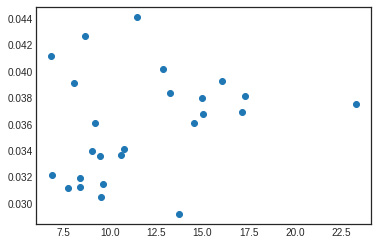

In [75]:
plt.scatter(times_old, emds_old)

## Sinkhorn

In [76]:
import torch
from torch.autograd import grad
from torch import optim
from geomloss import SamplesLoss

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [77]:
class CoolGaussian(object):

    def __init__(self, mean, std, z, N):

        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)
        self.z = torch.tensor(z)
        self.N = N

        self.parameters = [self.mean, self.std]

        self.t = self.sample(self.N)


    def sample(self,N):
        return torch.tensor(np.random.normal(size = (N, 2)))

    def get_event(self):
        self.t = self.sample(self.N)
        return (self.mean + self.t * self.std, self.z * torch.ones((self.N,)) / self.N)

    def print(self):
        pass

class MixtureModel(object):

    def __init__(self, shapes = None):

        self.shapes = shapes
        self.zs = [shape.z for shape in self.shapes]
        self.parameters = []
        for shape in shapes:
            self.parameters += shape.parameters

    def get_event(self):
        event = concatenate_events([shape.get_event() for shape in self.shapes])
        return event


    def normalize(self):
            
        z_test = activate(torch.tensor(self.zs).reshape((1, -1)))
        for (i, shape) in enumerate(self.shapes):
            shape.z.data = z_test[0,i]
        self.zs = [shape.z for shape in self.shapes]    


def concatenate_events(events):
    points, zs = [], []
    for event in events:
        points.append(event[0])
        zs.append(event[1])
    points = torch.cat(points, dim = 0)
    zs = torch.cat(zs, dim = 0)
    return (points, zs)


def activate(x):
    m, n = x.shape
    cnt_m = torch.arange(m, device=x.device)
    cnt_n = torch.arange(n, device=x.device)
    u = x.sort(dim=1, descending=True).values
    v = (u.cumsum(dim=1) - 1) / (cnt_n + 1)
    w = v[cnt_m, (u > v).sum(dim=1) - 1]
    return (x - w.view(m, 1)).relu()

In [78]:






def train(event, epochs = 500, early_stopping = 25, epsilon = 0.01):

    _2gaussians = MixtureModel(shapes = [CoolGaussian((-1.0,2.0), 0.5, 0.5, 250), CoolGaussian((+2.0,-1.0), 0.5, 0.5, 250)])
    count = 0
    min_loss = np.inf
    for i in range(epochs):
        loss = train_step(event, _2gaussians, i, epsilon = epsilon)
        if loss < min_loss:
            count = 0
            min_loss = loss
        else:
            count += 1
        if count == early_stopping:
            break

    for shape in _2gaussians.shapes:
        print(shape.parameters, shape.z)

    return min_loss

def train_step(event, observable, epoch, epsilon = 0.01, lr = 1.0):

    Loss = SamplesLoss("sinkhorn", p = 1, blur = epsilon)

    # Require grad:
    for shape in observable.shapes:
        shape.sample(shape.N)
        for parameter in shape.parameters:
            parameter.requires_grad = True
        shape.z.requires_grad = True

    # optimizer = optim.Adam(observable.parameters, lr = lr, betas=(0.9, 0.999))        

    # Create a copy of the data...
    x_i, a_i = event
    y_j, b_j = observable.get_event()

    # Compute the loss + gradients:
    Loss_xy = Loss(torch.tensor(a_i), torch.tensor(x_i), b_j, y_j) / R
    # Loss_xy.backward(retain_graph=True)
    # optimizer.step()
    for shape in observable.shapes: 
        param_grads = grad(Loss_xy, shape.parameters, retain_graph=True)
        z_grads = grad(Loss_xy, shape.z, retain_graph=True)
        for i,parameter in enumerate(shape.parameters):
            parameter.data -= lr * param_grads[i]
        shape.z.data -=  0.5* lr * z_grads[0]

    observable.normalize()
    # print("Epoch = ", epoch, "Loss = ", Loss_xy , ", zs = " ,observable.zs)

    # plt.scatter(x_i[:,0],x_i[:,1], sizes = 1000*a_i)
    # plt.scatter(y_j.detach().numpy()[:,0],y_j.detach().numpy()[:,1], sizes = 1000*b_j.detach().numpy())
    # plt.savefig("temp/epoch_%i.png" % epoch)
    # plt.close()

    return Loss_xy.detach().numpy()

print(train(events[0]))

[tensor([-0.8728, -0.3678], requires_grad=True), tensor(0.5790, requires_grad=True)] tensor(0.9999, requires_grad=True)
[tensor([ 0.8447, -0.7804], requires_grad=True), tensor(0.3941, requires_grad=True)] tensor(8.5835e-05, requires_grad=True)
0.027928718139739107


In [79]:
emds_001, times_001 = [], []
emds_01, times_01 = [], []
emds_1, times_1 = [], []

for (i,event) in enumerate(events):

    t1 = time()
    emd = train(event, epsilon = 0.001)
    t2 = time()
    emds_001.append(emd)
    times_001.append(t2 - t1)

    print("Event %d" %i, "Obs: %s" % "eps = 0.001","Value: %.3f" % emd, "Finished in %.3fs" % (t2 - t1))



for (i,event) in enumerate(events):

    t1 = time()
    emd = train(event, epsilon = 0.01)
    t2 = time()
    emds_01.append(emd)
    times_01.append(t2 - t1)

    print("Event %d" %i, "Obs: %s" % "eps = 0.01","Value: %.3f" % emd, "Finished in %.3fs" % (t2 - t1))


for (i,event) in enumerate(events):

    t1 = time()
    emd = train(event, epsilon = 0.1)
    t2 = time()
    emds_1.append(emd)
    times_1.append(t2 - t1)

    print("Event %d" %i, "Obs: %s" % "eps = 0.1","Value: %.3f" % emd, "Finished in %.3fs" % (t2 - t1))



[tensor([-0.8900, -0.3137], requires_grad=True), tensor(0.5875, requires_grad=True)] tensor(0.9998, requires_grad=True)
[tensor([ 0.8238, -0.7800], requires_grad=True), tensor(0.4018, requires_grad=True)] tensor(0.0002, requires_grad=True)
Event 0 Obs: eps = 0.001 Value: 0.029 Finished in 10.469s
[tensor([-1.4514, -0.2932], requires_grad=True), tensor(0.4750, requires_grad=True)] tensor(0.6118, requires_grad=True)
[tensor([ 1.9908, -1.9300], requires_grad=True), tensor(0.4591, requires_grad=True)] tensor(0.3882, requires_grad=True)
Event 1 Obs: eps = 0.001 Value: 0.024 Finished in 11.387s
[tensor([-1.3531,  0.4260], requires_grad=True), tensor(0.6423, requires_grad=True)] tensor(1., requires_grad=True)
[tensor([ 1.6133, -0.9258], requires_grad=True), tensor(0.4664, requires_grad=True)] tensor(0., requires_grad=True)
Event 2 Obs: eps = 0.001 Value: 0.064 Finished in 8.382s
[tensor([-1.4604, -0.1780], requires_grad=True), tensor(0.5894, requires_grad=True)] tensor(0.9818, requires_grad=T

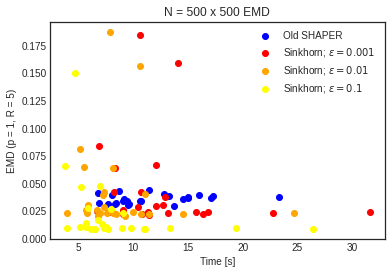

In [80]:
plt.scatter(times_old, emds_old, color = "blue", label = "Old SHAPER")
plt.scatter(times_001, emds_001, color = "red", label = "Sinkhorn; $\epsilon = 0.001$")
plt.scatter(times_01, emds_01, color = "orange", label = "Sinkhorn; $\epsilon = 0.01$")
plt.scatter(times_1, emds_1, color = "yellow", label = "Sinkhorn; $\epsilon = 0.1$")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("EMD (p = 1, R = 5)")
plt.title("N = 500 x 500 EMD")

plt.savefig("timeplot.png")


In [85]:
Loss = SamplesLoss("sinkhorn", p = 1, blur = 0.001)
x_i, a_i = np.array(((-1.0,0.0), (+1.0,0.0))), np.array((0.5, 0.5))
y_j, b_j = np.array(((0.0,0.0), )), np.array((1.0,))

Loss_xy = Loss(torch.tensor(a_i), torch.tensor(x_i), torch.tensor(b_j), torch.tensor(y_j))
print(Loss_xy)


tensor(0.9996, dtype=torch.float64)
